#Importing packages

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd 
import os
import cv2
import csv
import copy
import shutil
import math
import random
import PIL

from collections import Counter
from PIL import Image
from random import sample, choices
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
%matplotlib inline
matplotlib.style.use("ggplot")

import tensorflow as tf
from tensorflow import keras

import keras.preprocessing.image
from keras import regularizers
from keras.applications import imagenet_utils
from keras.layers import Lambda, Reshape, Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, Conv2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import Input, optimizers, layers, models, callbacks, applications
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from skimage.transform import resize
from IPython.display import SVG

Since the dataset is too big to add to Google Colab runfiles, it must be imported from Google Drive. First, we mount the drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Descriptive Analysis

Caltech-UCSD Birds-200-2011 (CUB-200-2011) is an extended version of the CUB-200 dataset, with roughly double the number of images per class and new part location annotations. For detailed information about the dataset, please see the technical report linked below.

Number of categories: 200

Number of images: 11,788

Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

Before we can analyse the images and their properties, we must upload the dataset from Google Drive:

In [ ]:
#Upload the folder containing all the images
#was train_root
image_folder = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/images'

#Upload the text file with the names of each image in the dataset
#This will be used as the "path" to find images
path_txt = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/images.txt'

In [ ]:
#Define a path to the list of images with their class labels
img_label_txt = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/image_class_labels.txt'

#Create an empty array ready to input number of images per class
label_list = []

#Open the class label assignments text file
fp = open(img_label_txt)

#Use a for loop to transfer the classes to the array
for line in fp:
    #extract the image number and class label
    idx, label = line.strip().split()
    #append empty array with class label only
    label_list.append(int(label) - 1)

#Close the text file so it doesn't get altered
fp.close()

##Looking at the Images

Let's have a look at a few of the images:

A small sample of unprocessed images:


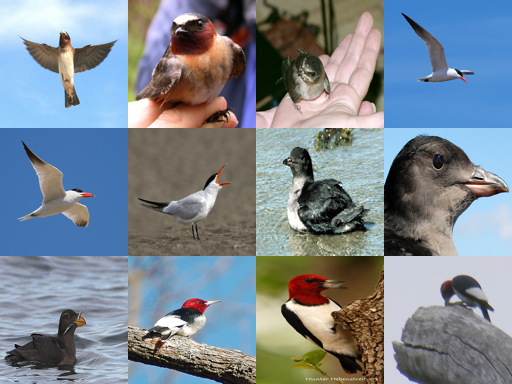

In [ ]:
#Specify some variables for printing out the pictures:
n_col = 4 #number of columns
n_row = 3 #number of rows
n_spec = 3 #number of spec??
img_h = 128 #the height of an image
img_w = 128 #the width of an image

#Create an empty array to put the image path lists into?
img_path_list = []

#Open the images text file
fp = open(path_txt)

#Use a for loop to run through each line of the text file and make a list of labels
for line in fp:
  #Get the index and path of each image
  idx, img_path = line.strip().split() #gets rid of white space
  #Join the path to the images folder with the path to an individual image,
  #then append this to the overall image path list
  img_path_list.append(os.path.join(image_folder, img_path))

#Close the file after use
fp.close()

#Create an empty list ready to input bird labels
label_idx_list = [[] for i in range(200)] #there are 200 labels

#Use a for loop to create the list of labels
for idx in range(len(label_list)):
    label = label_list[idx]
    label_idx_list[label].append(idx)

#Not sure what this does
n_pre_spec = n_col*n_row//n_spec 
pre_spec_list = sample(range(200), n_pre_spec)

#Create an empty array for the list to random sample of images
path_list = []

#Use a for loop to fill the array with a small sample of random image path lists
for label in pre_spec_list:
    #extract a random image path
    sampled_idx = sample(label_idx_list[label], n_spec)
    for idx in sampled_idx:
        #append the array with the image path
        path_list.append(img_path_list[idx])

#Create an empty array for the sample of images
imgs = []

#Use a for loop to fill the array with 9 random images
print("A small sample of unprocessed images:")
for idx in range(n_col*n_row):
    #get image path
    img = Image.open(path_list[idx])
    #resize image to be same size as others
    img = img.resize((128,128))
    #append the array with the image data
    imgs.append(img)

#Use a second for loop to paste the images into a 4x3 grid
target = Image.new('RGB', (img_w * n_col, img_h * n_row)) 
for r in range(n_row):
    for c in range(n_col):
        target.paste(imgs[n_col*r+c], (0 + img_w*c, 0 + img_h*r))

display(target)
save_name = 'overview.jpg'
target.save(save_name, quality=100) 

We can also look at samples of birds from particular classes:


In [ ]:
#Create a function that extracts 3 random sample images for the inputted class
def BirdView(genera):
  #genera is the class of the bird
  print("Samples images for Bird " + genera)
  #define a path to the images
  root_path='/content/drive/MyDrive/CMT307_15/CUB_200_2011/images/'
  #pick 3 random images from the class folder
  img_path=root_path+genera+'/**'
  images = glob(img_path)
  #plot a figure with 3 subplots and paste images
  plt.figure(figsize=(16,16))
  img=random.sample(images,10)
  plt.subplot(131)
  plt.imshow(cv2.imread(img[0]))
  plt.subplot(132)
  plt.imshow(cv2.imread(img[1]))
  plt.subplot(133)
  plt.imshow(cv2.imread(img[2]))
  return

Sample of Black-footed Albatross:
Samples images for Bird 001.Black_footed_Albatross


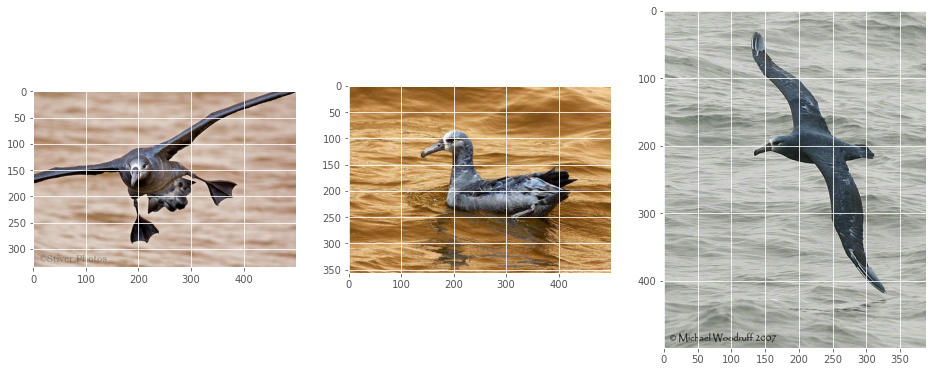

In [ ]:
#Test the function to see if it works
print('Sample of Black-footed Albatross:')
BirdView('001.Black_footed_Albatross')

##Overall Statistical Properties

We will now look at the overall properties of the dataset, starting with how many images are in each class. In order to calculate this, we need to first upload the classes textfile from the dataset and convert it into a dictionary:

In [ ]:
#Create an empty dictionary ready to input class names
labels_dict={}

#Open the text file containing the class names
#Read mode means we cannot accidentally change any of the data in this file
f = open('/content/drive/MyDrive/CMT307_15/CUB_200_2011/classes.txt', 'r')

#Use a for loop to extract the name of each class and it's number
#The name of each class will be the key
for line in f:
    value, key = line.split(' ') #split into number value and key (name)
    labels_dict[key[:-1]] = int(value) #inserts key and value into dictionary

#Close the file after use
f.close()

#Print the classes to check the dictionary is correctly created
print("Check the dictionary is created correctly:")
print(labels_dict)

Check the dictionary is created correctly:
{'001.Black_footed_Albatross': 1, '002.Laysan_Albatross': 2, '003.Sooty_Albatross': 3, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 5, '006.Least_Auklet': 6, '007.Parakeet_Auklet': 7, '008.Rhinoceros_Auklet': 8, '009.Brewer_Blackbird': 9, '010.Red_winged_Blackbird': 10, '011.Rusty_Blackbird': 11, '012.Yellow_headed_Blackbird': 12, '013.Bobolink': 13, '014.Indigo_Bunting': 14, '015.Lazuli_Bunting': 15, '016.Painted_Bunting': 16, '017.Cardinal': 17, '018.Spotted_Catbird': 18, '019.Gray_Catbird': 19, '020.Yellow_breasted_Chat': 20, '021.Eastern_Towhee': 21, '022.Chuck_will_Widow': 22, '023.Brandt_Cormorant': 23, '024.Red_faced_Cormorant': 24, '025.Pelagic_Cormorant': 25, '026.Bronzed_Cowbird': 26, '027.Shiny_Cowbird': 27, '028.Brown_Creeper': 28, '029.American_Crow': 29, '030.Fish_Crow': 30, '031.Black_billed_Cuckoo': 31, '032.Mangrove_Cuckoo': 32, '033.Yellow_billed_Cuckoo': 33, '034.Gray_crowned_Rosy_Finch': 34, '035.Purple_Finch': 35, '03

Now that we have the dictionary of classes, we can have a look at some of the global properties of the dataset. First, we look at the statistical values in each class:

In [ ]:
#Create an array of 200 zeroes to count the number of images in each class
class_cnt = np.zeros(200)

#Use a for loop to +1 every time there is an image in that class
for label in label_list:
    class_cnt[label] += 1

#Calculate statistical properties
class_mean = np.mean(class_cnt)
class_max = np.max(class_cnt)
class_min = np.min(class_cnt)
class_median = np.median(class_cnt)
class_var = np.var(class_cnt)
class_std = np.std(class_cnt)

#Print statistical properties
print(f'Mean number of images per class: {class_mean:.2f}')
print(f'Median number of images per class: {class_median:.2f}')
print(f'Maximum number of images per class: {class_max:.2f}')
print(f'Minimum number of images per class: {class_min:.2f}')
print(f'Variance of number of images per class: {class_var:.2f}')
print(f'Standard deviation of number of images per class: {class_std:.2f}')

Mean number of images per class: 58.94
Median number of images per class: 60.00
Maximum number of images per class: 60.00
Minimum number of images per class: 41.00
Variance of number of images per class: 8.48
Standard deviation of number of images per class: 2.91


From this analysis, we can see that the median value is 60, which means that most of the classes have 60 images assigned to them.  
  
There is not a large variance in the number of images per class, which is good because there are no classes that are sparse. This will help when splitting the data, as all the classes are fairly evenly populated. As a result, we will not need to use over-sampling or under-sampling to compensate for sparse class labels.  
  
We can visualise this more accurately by plotting a graph of the number of images in each class:

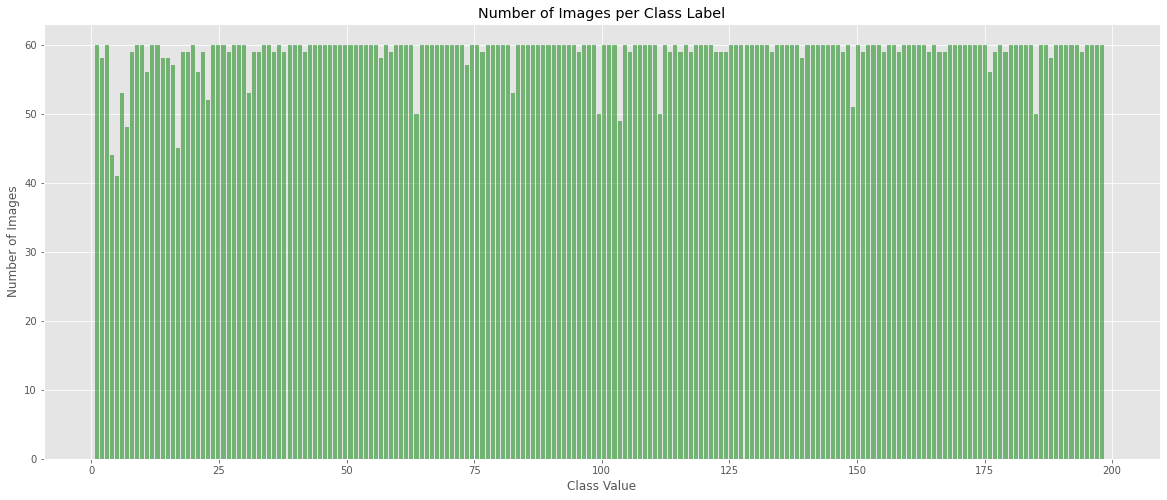

In [ ]:
#Plot a figure
plt.figure(figsize=(20, 8))

#We have already created a list of images per label, so we just need to
#convert this to an array for plotting
data = np.array(label_list) 

#Plot a histogram 
plt.hist(data, bins=200 ,range=(1,200), rwidth=0.8,align='left',  facecolor="green", edgecolor="none", alpha=0.5)
plt.xlabel("Class Value")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class Label")
plt.show()

The histogram of data above proves that most of the classes are populated with ~60 images. The lowest number of images in a class is not low enough that we need to use over/under sampling to compensate.

##Image Properties

Now that we have looked at the statistical properties of the overall dataset, we can look more closely at the properties of the images themselves.  
  
First, we will look at the average image dimensions:

In [ ]:
#Create empty arrays ready for input
h_list = [] #image height
w_list = [] #image width
s_list = [] #overall image size

#Use a for loop to populate the arrays
for img_path in img_path_list:
    #open the image
    img = Image.open(img_path)
    #extract size of image
    img_size = img.size
    #append height and width of image
    w_list.append(img_size[0])
    h_list.append(img_size[1])
    s_list.append(img_size[0] + img_size[1])

In [ ]:
print(f'The average image size is: {np.mean(s_list):.2f}')
print(f'The average image height is: {np.mean(h_list):.2f}')
print(f'The average image width is: {np.mean(w_list):.2f}')
print(f'The biggest image size is: {np.max(s_list):.2f}')
print(f'The smallest image size is: {np.min(s_list):.2f}')

The average image size is: 853.92
The average image height is: 386.03
The average image width is: 467.89
The biggest image size is: 1000.00
The smallest image size is: 279.00


We can break this down further to look at the distribution of image heights, widths and overall sizes.

The number of unique image sizes in the height array is: 335


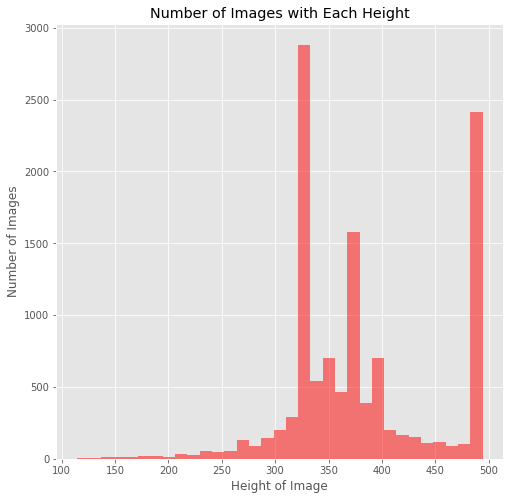

In [ ]:
#Use Counter to find the number of unique image sizes in the height array
h_cnt = len(Counter(h_list))
print(f'The number of unique image sizes in the height array is: {h_cnt}')
bins_no = h_cnt//10

#Plot a histogram of the image heights
#Here we have used the number of unique image heights divided by 10,
#because 335 bins is too many to be able to see the population properties
plt.figure(figsize=(8, 8))
plt.hist(h_list, bins=bins_no, align='left', facecolor="red", edgecolor="none", alpha=0.5)
plt.xlabel("Height of Image")
plt.ylabel("Number of Images")
plt.title("Number of Images with Each Height")
plt.show()

The number of unique image sizes in the width array is: 283


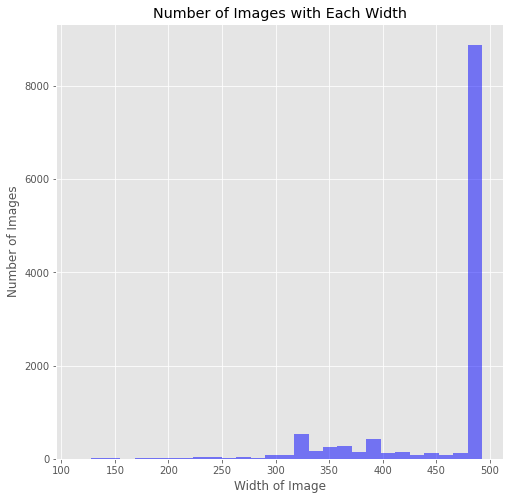

In [ ]:
#Use Counter to find the number of unique image sizes in the width array
w_cnt = len(Counter(w_list))
print(f'The number of unique image sizes in the width array is: {w_cnt}')
bins_no = w_cnt//10

#Plot a histogram of the image widths
#Here we have used the number of unique image widths divided by 10,
#because 283 bins is too many to be able to see the population properties
plt.figure(figsize=(8, 8))
plt.hist(w_list, bins=bins_no, align='left', facecolor="blue", edgecolor="none", alpha=0.5)
plt.xlabel("Width of Image")
plt.ylabel("Number of Images")
plt.title("Number of Images with Each Width")
plt.show()

The number of unique image sizes is: 530


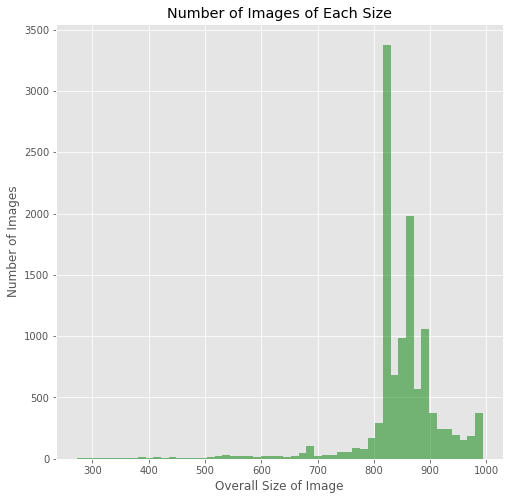

In [ ]:
#Use Counter to find the number of unique image sizes in the width array
s_cnt = len(Counter(s_list))
print(f'The number of unique image sizes is: {s_cnt}')
bins_no = s_cnt//10

#Plot a histogram of the image sizes
#Here we have used the number of unique image sizes divided by 10,
#because X bins is too many to be able to see the population properties
plt.figure(figsize=(8, 8))
plt.hist(s_list, bins=bins_no, align='left', facecolor="green", edgecolor="none", alpha=0.5)
plt.xlabel("Overall Size of Image")
plt.ylabel("Number of Images")
plt.title("Number of Images of Each Size")
plt.show()

We can also look at the colour channels of the images. We know that there are 3 colour channels - 'R' (red), 'G' (green) and 'B' (blue).  
  
Using the mean image size from above, we can calculate the overall statistical properties of each channel, in the code below.  
  
Since we know that the images are not all the same size, we have to resize them when we do this so that we can fairly compare each colour channel. We also have to divide the image colour values by 225, because standard colour channel processing packages (e.g. `matplotlib`) use a colour scale of 0 - 1. This dataset has a colour scale of 0 - 225, so we have to scale it down.

In [ ]:
#Define the height and width we want the images to be
#We have to resize the images to be the same so that we can compare their channels
img_h, img_w = 448, 448

#Create zero arrays for mean and std of each colour channel
means = [0, 0, 0]
stdevs = [0, 0, 0]

#Find the number of images using the length of our iamge array from earlier
num_imgs = len(img_path_list)

#Use a for loop to cumulatively calculate the mean and std of each colour channel
for i in range(len(img_path_list)):
    img = cv2.imread(img_path_list[i])
    #resize each image so that we can compare them
    img = cv2.resize(img,(img_w,img_h))
    #convert to an array
    img = np.asarray(img)
    #scale colour channels so they go 0 - 1
    img = img.astype(np.float32) / 255.
    #use a second for loop to add mean and std values to arrays
    for c in range(3):
        means[c] += img[:, :, c].mean()
        stdevs[c] += img[:, :, c].std()
    #this just prints out each 1000 images so we know how long it is taking
    if i%1000 == 0:
        print(i,'/',num_imgs)  

#Why do we reverse these?
means.reverse()
stdevs.reverse()

#Convert mean/std values into an array and divide by the number of images
#to get the overall mean/std for each image
means = np.asarray(means) / num_imgs
stdevs = np.asarray(stdevs) / num_imgs

#Print out results
print('Channels: R, G, B ')
print("Dataset Mean = {}".format(means))
print("Dataset Std = {}".format(stdevs))

0 / 11788
1000 / 11788
2000 / 11788
3000 / 11788
4000 / 11788
5000 / 11788
6000 / 11788
7000 / 11788
8000 / 11788
9000 / 11788
10000 / 11788
11000 / 11788
Channels: R, G, B 
Dataset Mean = [0.4854438  0.49915099 0.43130941]
Dataset Std = [0.17901957 0.17794788 0.18994176]
